In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import pandas as pd
from pathlib import Path

from calicost import arg_parse, parse_input, utils_IO, utils_hmm, utils_hmrf, utils_plotting, utils_phase_switch, hmrf

from matplotlib import pyplot as plt
import seaborn
import scanpy as sc
import anndata
from sklearn.metrics import silhouette_score, adjusted_rand_score
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

import warnings
from numba.core.errors import NumbaDeprecationWarning

In [3]:
from sim_analysis import (
    get_best_r_hmrf,
    read_gene_loc,
    read_true_gene_cna,
    read_calico_gene_cna,
    read_numbat_gene_cna,
    read_starch_gene_cna,
    compute_gene_F1,
    get_aris, 
    plot_aris,
    get_f1s,
    plot_f1s
)

## Configuration

In [4]:
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

In [5]:
pd.set_option('display.max_rows', 10)
plt.rcParams.update({'font.size': 14})
sc.set_figure_params(dpi=120)

In [6]:
! pwd

/Users/mw9568/Work/ragr/sim/calicost_sim


In [7]:
true_dir = "../simulated_data_related/"
calico_pure_dir = "../nomixing_calicost_related/"
numbat_dir = "../numbat_related/"
starch_dir = "../starch_related/"

# hg_table_file = "/nfs/turbo/umms-congma1/projects/CalicoST/GRCh38_resources/hgTables_hg38_gencode.txt"
hg_table_file = "/Users/mw9568/Work/ragr/CalicoST/GRCh38_resources/hgTables_hg38_gencode.txt"

# Clone identification accuracy

In [8]:
clone_aris = get_aris(true_dir, calico_pure_dir, numbat_dir, starch_dir)
clone_aris

,cnas,n_cnas,cna_size,random,ploidy,method,ARI,sample_id,r_calico,true_clones_path,best_fit_clones_path
0,"(1, 2)",3,10Mb,0,2,CalicoST,0.694395,numcnas1.2_cnasize1e7_ploidy2_random0,1.0,../simulated_data_related//numcnas1.2_cnasize1...,../nomixing_calicost_related//numcnas1.2_cnasi...
1,"(1, 2)",3,10Mb,0,2,Numbat,0.000000,numcnas1.2_cnasize1e7_ploidy2_random0,NaN,../simulated_data_related//numcnas1.2_cnasize1...,-
2,"(1, 2)",3,10Mb,0,2,STARCH,0.585557,numcnas1.2_cnasize1e7_ploidy2_random0,NaN,../simulated_data_related//numcnas1.2_cnasize1...,../starch_related//numcnas1.2_cnasize1e7_ploid...
3,"(1, 2)",3,10Mb,1,2,CalicoST,0.651819,numcnas1.2_cnasize1e7_ploidy2_random1,1.0,../simulated_data_related//numcnas1.2_cnasize1...,../nomixing_calicost_related//numcnas1.2_cnasi...
4,"(1, 2)",3,10Mb,1,2,Numbat,0.000000,numcnas1.2_cnasize1e7_ploidy2_random1,NaN,../simulated_data_related//numcnas1.2_cnasize1...,-
...,...,...,...,...,...,...,...,...,...,...,...
265,"(6, 3)",9,50Mb,8,2,Numbat,0.396501,numcnas6.3_cnasize5e7_ploidy2_random8,NaN,../simulated_data_related//numcnas6.3_cnasize5...,../numbat_related//numcnas6.3_cnasize5e7_ploid...
266,"(6, 3)",9,50Mb,8,2,STARCH,0.911511,numcnas6.3_cnasize5e7_ploidy2_random8,NaN,../simulated_data_related//numcnas6.3_cnasize5...,../starch_related//numcnas6.3_cnasize5e7_ploid...
267,"(6, 3)",9,50Mb,9,2,CalicoST,0.942561,numcnas6.3_cnasize5e7_ploidy2_random9,0.0,../simulated_data_related//numcnas6.3_cnasize5...,../nomixing_calicost_related//numcnas6.3_cnasi...
268,"(6, 3)",9,50Mb,9,2,Numbat,0.848603,numcnas6.3_cnasize5e7_ploidy2_random9,NaN,../simulated_data_related//numcnas6.3_cnasize5...,../numbat_related//numcnas6.3_cnasize5e7_ploid...


/Users/mw9568/Work/ragr/sim/calicost_sim/sim_analysis.py:488: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


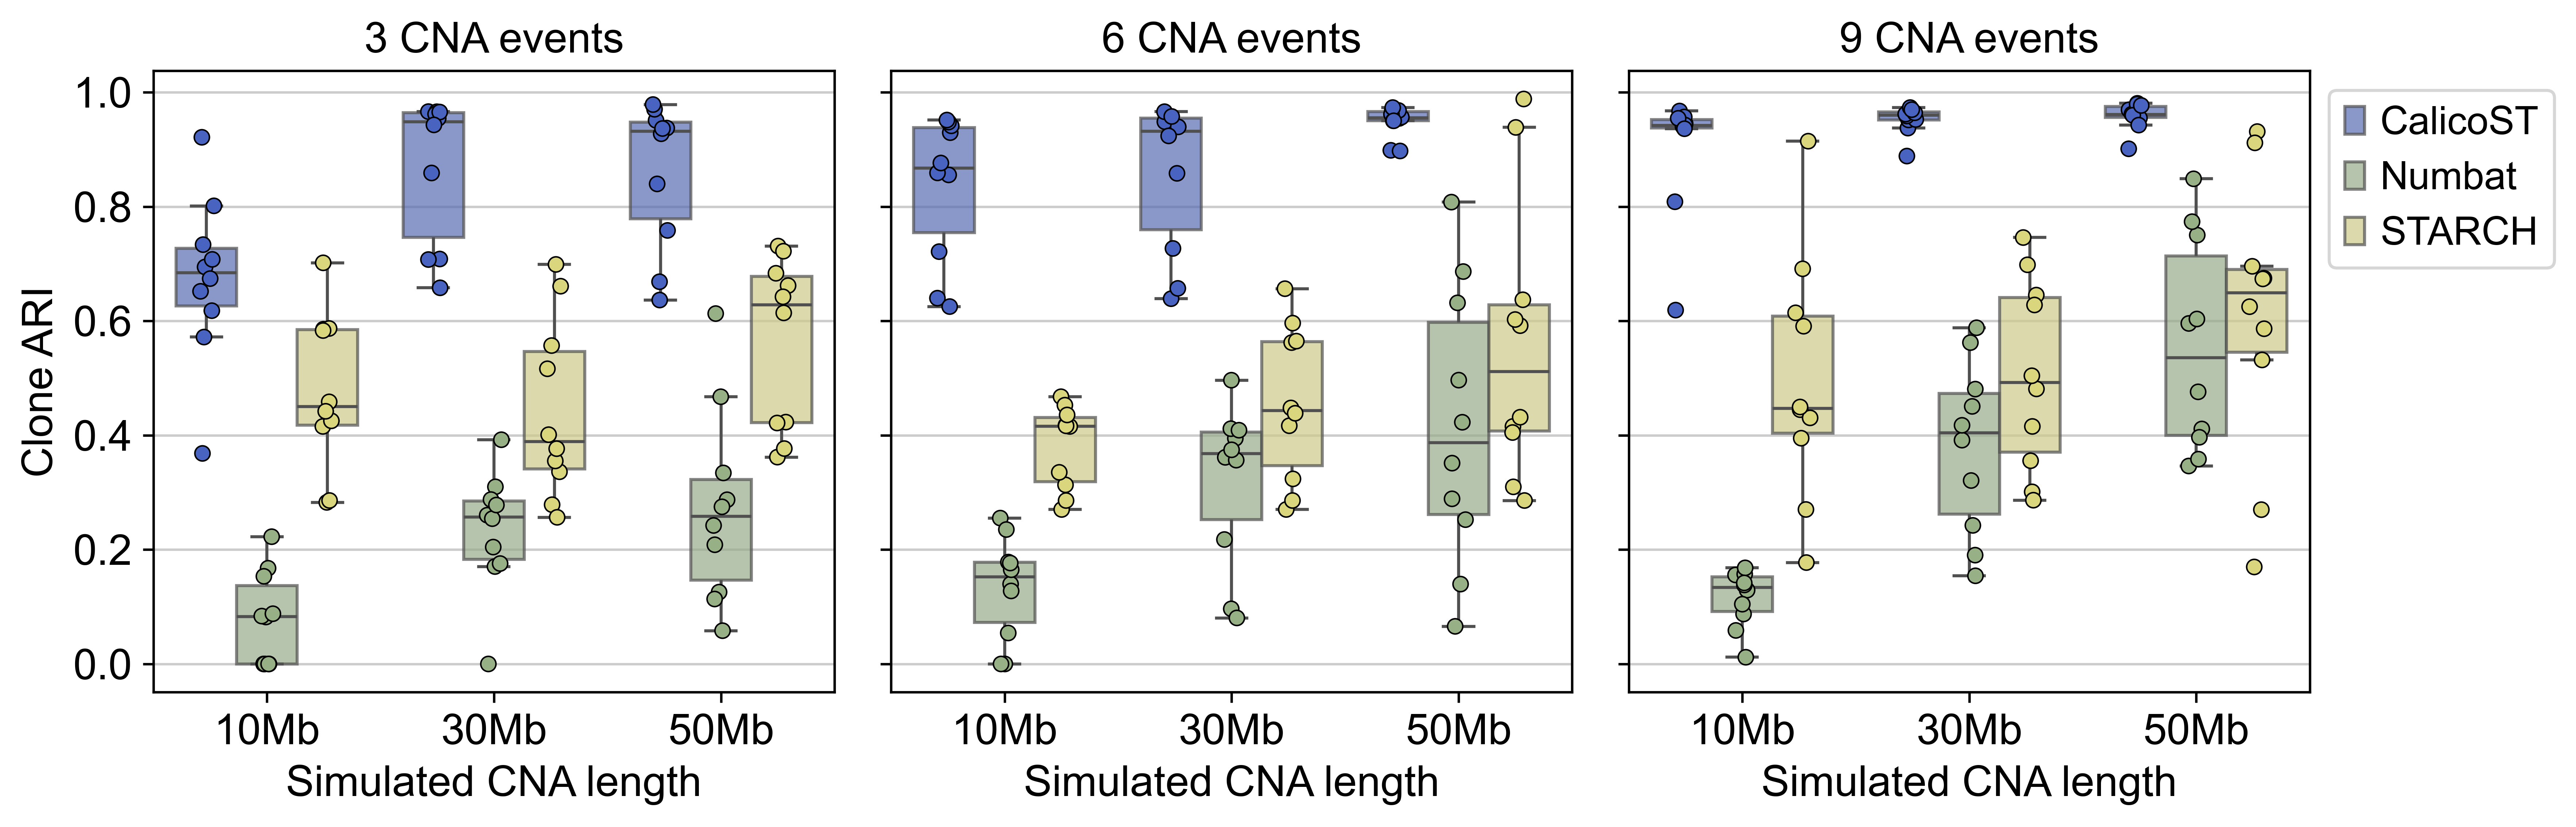

In [9]:
plot_aris(clone_aris)

# Event detection accuracy

The detection accuracy is evalated on a per-gene level:
the precision & sensitivity of genes involved in each category of event (Deletion, Amplication, LOH) for all events.

In [10]:
# NB (chr, start, end) for a given gene list.
df_hgtable = read_gene_loc(hg_table_file)
df_hgtable

,chr,start,end
name2,,,
FAM138A,1,34554,36081
OR4F5,1,65419,71585
AL627309.1,1,89295,133723
AL627309.3,1,89551,91105
AL627309.2,1,139790,140339
...,...,...,...
SHANK3,22,50674415,50733298
AC000036.1,22,50735825,50738139
ACR,22,50738196,50745339


In [11]:
df_event_f1 = get_f1s(true_dir, df_hgtable, calico_pure_dir, numbat_dir, starch_dir)
df_event_f1

,cnas,n_cnas,cna_size,random,ploidy,sample_id,method,event,F1,true_cna,config
0,"(1, 2)",3,1e7,0,2,numcnas1.2_cnasize1e7_ploidy2_random0,CalicoST,DEL,0.378378,../simulated_data_related//numcnas1.2_cnasize1...,../nomixing_calicost_related//numcnas1.2_cnasi...
1,"(1, 2)",3,1e7,0,2,numcnas1.2_cnasize1e7_ploidy2_random0,CalicoST,AMP,0.115756,../simulated_data_related//numcnas1.2_cnasize1...,../nomixing_calicost_related//numcnas1.2_cnasi...
2,"(1, 2)",3,1e7,0,2,numcnas1.2_cnasize1e7_ploidy2_random0,CalicoST,CNLOH,0.790698,../simulated_data_related//numcnas1.2_cnasize1...,../nomixing_calicost_related//numcnas1.2_cnasi...
3,"(1, 2)",3,1e7,0,2,numcnas1.2_cnasize1e7_ploidy2_random0,CalicoST,overall,0.219251,../simulated_data_related//numcnas1.2_cnasize1...,../nomixing_calicost_related//numcnas1.2_cnasi...
4,"(1, 2)",3,1e7,0,2,numcnas1.2_cnasize1e7_ploidy2_random0,Numbat,DEL,0.000000,../simulated_data_related//numcnas1.2_cnasize1...,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1075,"(6, 3)",9,5e7,9,2,numcnas6.3_cnasize5e7_ploidy2_random9,Numbat,overall,0.863992,../simulated_data_related//numcnas6.3_cnasize5...,NaN
1076,"(6, 3)",9,5e7,9,2,numcnas6.3_cnasize5e7_ploidy2_random9,STARCH,DEL,0.134228,../simulated_data_related//numcnas6.3_cnasize5...,NaN
1077,"(6, 3)",9,5e7,9,2,numcnas6.3_cnasize5e7_ploidy2_random9,STARCH,AMP,0.000000,../simulated_data_related//numcnas6.3_cnasize5...,NaN
1078,"(6, 3)",9,5e7,9,2,numcnas6.3_cnasize5e7_ploidy2_random9,STARCH,CNLOH,0.000000,../simulated_data_related//numcnas6.3_cnasize5...,NaN


/Users/mw9568/Work/ragr/sim/calicost_sim/sim_analysis.py:644: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
/Users/mw9568/Work/ragr/sim/calicost_sim/sim_analysis.py:644: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
/Users/mw9568/Work/ragr/sim/calicost_sim/sim_analysis.py:644: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
/Users/mw9568/Work/ragr/sim/calicost_sim/sim_analysis.py:650: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


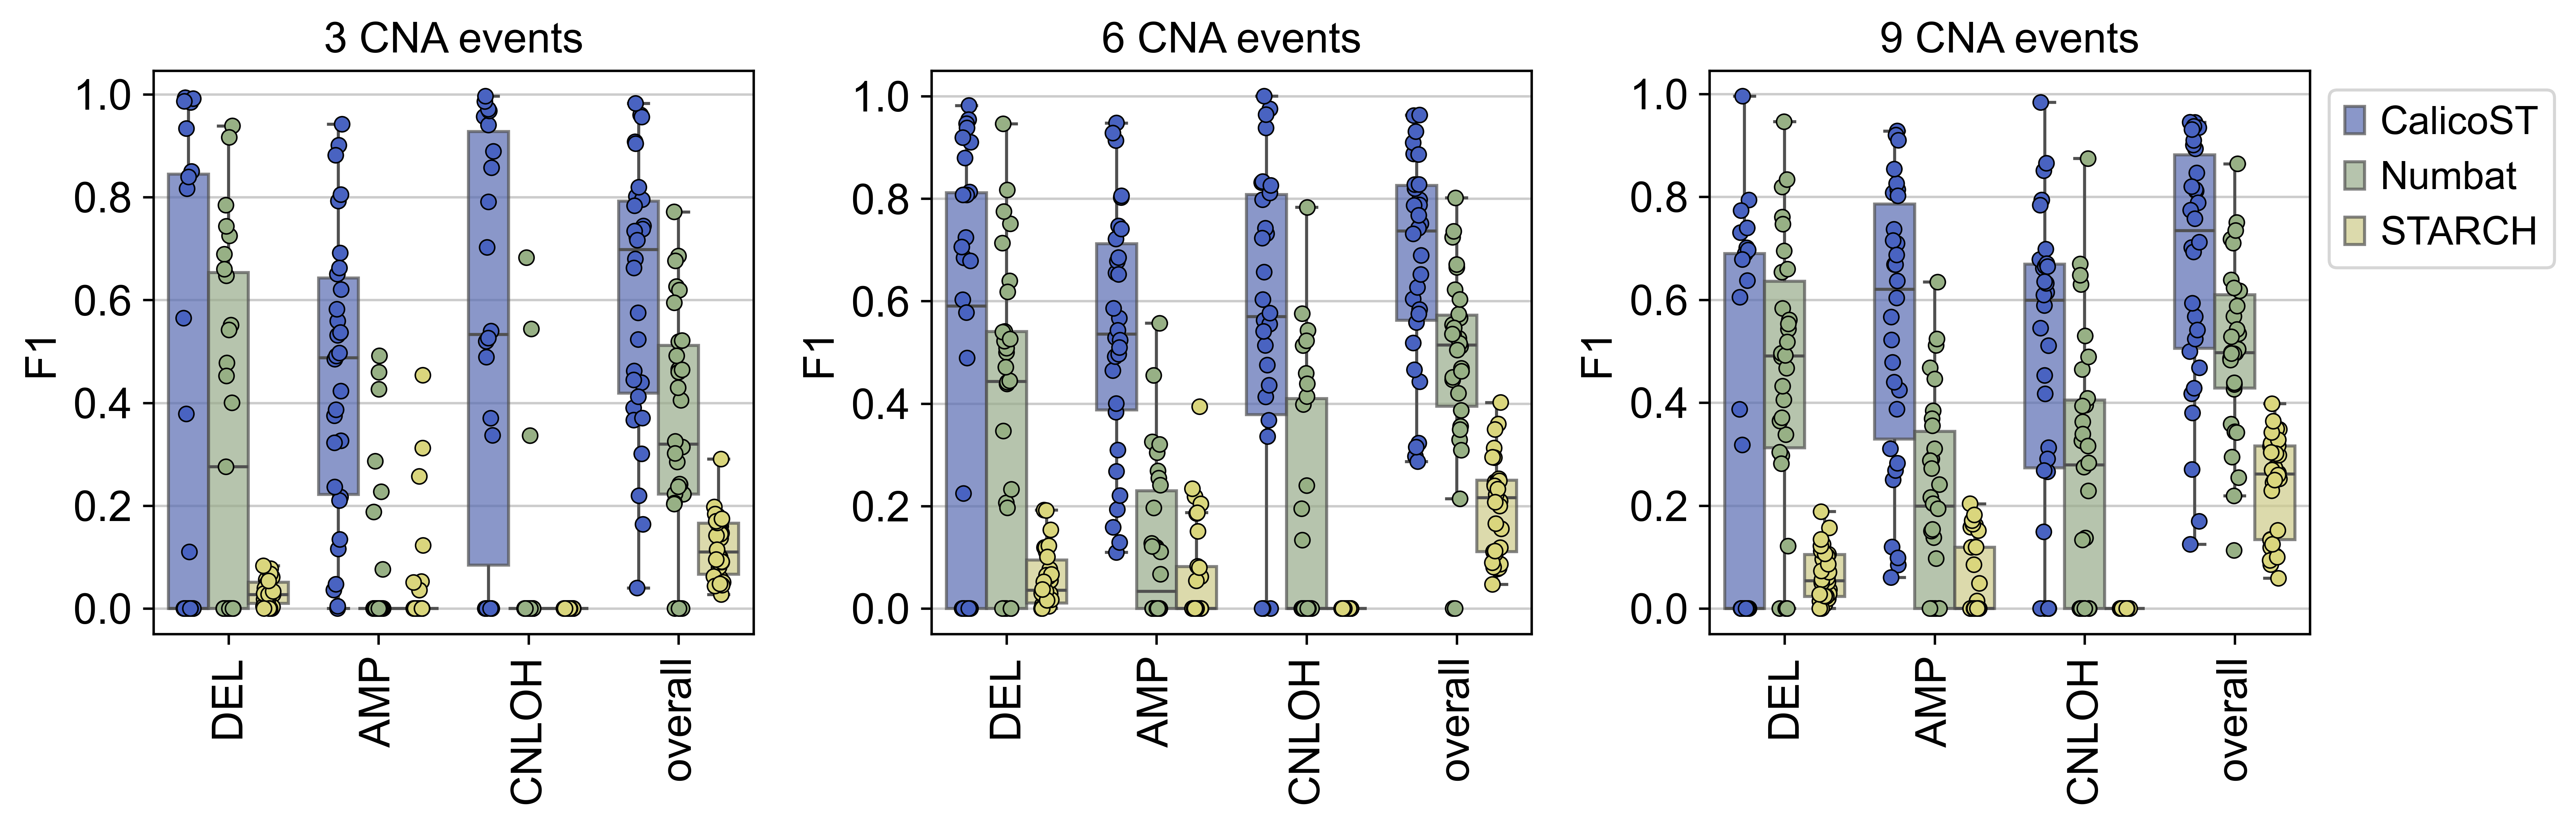

In [12]:
plot_f1s(df_event_f1)

# Done.